## Model Fitting Part 3: PCA-based Face Recognition

[Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) a statistical procedure to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables. Each of the principal components is chosen in such a way that it would describe most of the still available variance and all these principal components are orthogonal to each other.

For example, in the image below, there is a collection of data points that are made up of two features, Feature 1 and Feature 2. The red arrow is parallel to the first principal component, which also the direction of the highest variance. The green arrow is parallel to the second principal component, and it is the direction of highest variance orthogonal to the first one. 

![PCA eigenvectors](img/pca_eigen.png)

After calculating the principal components, we can use them to transform the data into a new space. The new space is a subspace of the original space, where the first principal component is the direction of the highest variance. The second principal component is the direction of the highest variance orthogonal to the first one. The third principal component is the direction of the highest variance orthogonal to the first two, and so on. In this new space we can drop a dimension of low variance, and project the data points to the remaining dimensions. By only dropping dimensions of low variance, we can reduce the dimensionality of the data, while still retaining the majority of the information.

![PCA project](img/pca-projection.png)

Effectively, we can use the projection matrix of eigenvectors computed by PCA to represent high dimensional data in a low dimensional space, and we can use the eigenvectors to transform the data back to the original space. During this transformation process some information is lost, so the reconstructed data are not exactly the same as the original data, but they are close.

Let's now dive into how PCA works.

- **Step 1:** Load a set of face images and convert the images to vectors. The vectors are the data points that are used to compute the PCA. To convert a 2D grayscale image of dimensions H-by-W to a vector, we can simply take the pixels of the image and convert them to a 1D array of length M = H*W, by concatenating all the rows of the image horizontally.
- **Step 2:** Compute the mean of the vectors. The mean is the average of all the vectors. Normalize the vectors by subtracting the mean from each vector.
- **Step 3:** Compute the covariance matrix. The covariance matrix is a matrix that contains the covariance of each pair of vectors. The covariance of two vectors is the dot product of the difference between the two vectors and mean vector. The covariance matrix is a M-by-M matrix, where M is the dimensionality of the vectors.
- **Step 4:** Compute the eigenvectors and eigenvalues of the covariance matrix. The eigenvectors are unit vectors that point in the same directions as the principal components of the data, and the eigenvalues are the variances of the principal components.
- **Step 5:** Project the data onto the principal components. The projection of a vector x onto a set of principal components is the dot product of x and the eigenvectors corresponding to the largest eigenvalues.
- **Step 6:** Reconstruct the data from the projected data. The reconstructed data is the sum of the back-projected data and the mean.

In [1]:
# Necessary imports
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os

# Step 1: Load the images and convert them to vectors
filenames = [ 'data/faces/' + filename for filename in os.listdir('data/faces') ]

face_vectors = []
for filename in filenames:
    img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    img = img[25:85, 25:75]  # Crop the face

    img_vector = img.flatten() # Convert image to a column vector
    face_vectors.append(img_vector) # Add the vector to the list


# Convert the face vectors to a numpy array
face_vectors = np.column_stack(face_vectors)

# Step 2: Compute the average face vector
average_face_vector = np.mean(face_vectors, axis = 1)

# Convert dimensionality from (3000,) to (3000, 1) to allow matrix multiplication
average_face_vector = average_face_vector[:, np.newaxis] 

# Normalize each face vector by subtracting the average face vector
face_vectors_normalized = face_vectors - average_face_vector

# Step 3: Compute the covariance matrix
covariance_matrix = np.cov(face_vectors_normalized, rowvar = True)

# Step 4: Compute the eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

We have now computed the eigenvectors and eigenvalues of the covariance matrix. We can now use the eigenvectors to project the data onto the principal components. Before we do so, let's first visualize the top 10 (most significant) eigenvectors to see what they look like. Those will resemble faces. Each one of the eigenvectors captures some property of the face. If, on the other hand, we visualize the bottom 10 (least significant) eigenvectors, we will mostly appear as noise. To visualize the eigenvectors we reshape them back to 2D images. Those images also known as **eigenfaces**.

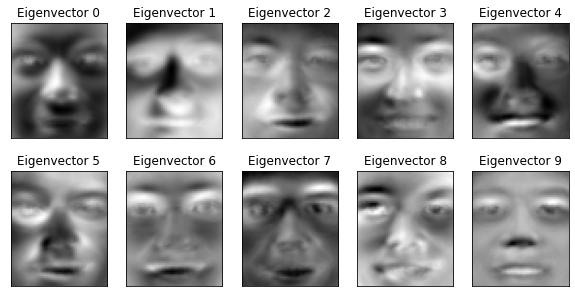

In [2]:
# Sort the eigenvectors and eigenvalues in descending order of eigenvalues
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Visualize the top 10 eigenvectors
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1), plt.imshow(eigenvectors[:,i].reshape(60,50), cmap='gray')
    plt.title("Eigenvector " + str(i)), plt.xticks([]), plt.yticks([])
plt.show()

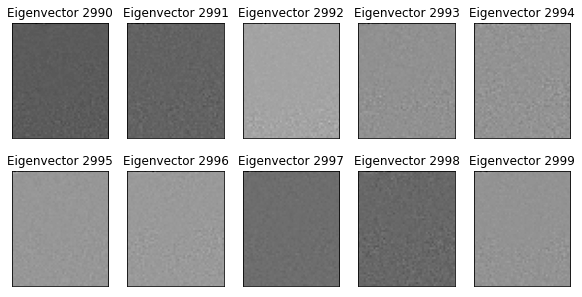

In [3]:
# Visualize the bottom 10 eigenvectors
plt.figure(figsize = (10,5))
for i in range(10):
    index = eigenvectors.shape[1] - (10 - i)
    plt.subplot(2,5,i+1), plt.imshow(eigenvectors[:, index].reshape(60,50), cmap='gray')
    plt.title("Eigenvector " + str(index)), plt.xticks([]), plt.yticks([])
plt.show()

Let's now see how we can reduce the dimensionality of a face image by projecting it onto a few principal components. We will start by projecting the face to only the **first principal component**.

In [4]:
face_vector = face_vectors[:, 40] # Select a random face vector

# Convert from (3000,) to (3000, 1) to allow matrix multiplication
face_vector = face_vector[:, np.newaxis]

# Normalize the face vector by subtracting the average face vector
face_vector_normalized = face_vector - average_face_vector

num_of_eigenvectors = 1     # Number of eigenvectors to use

# Project the face vector onto the eigenvectors to get the feature vector
# To project we compute the dot product of the transpose of the eigenvectors and the face vector
projected_face = (eigenvectors[:, :num_of_eigenvectors].T).dot(face_vector_normalized)

print('Projected face: ', projected_face)

Projected face:  [[1022.83769078]]


As we can see, the result of projecting a face to the first principal component is a scalar number. That is expected as the dot product of two matrices of shapes (1, 3000) x (3000, 1) is a matrix of dimension (1, 1), or scalar. Effectively, we are approximating the face with a single number. Let's now try to reconstruct the face by back-projecting it to its original shape. To do so, we need to multiply the projected data by the first eigenvector and add the mean.

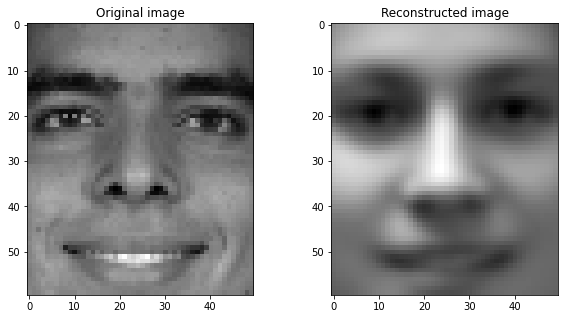

In [5]:
reconstructed_face_vector = (eigenvectors[:, :num_of_eigenvectors]).dot(projected_face) + average_face_vector

# Visualize the reconstructed face
face = face_vector.reshape(60, 50)
reconstructed_face = reconstructed_face_vector.reshape(60, 50)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(face, cmap='gray'), plt.title('Original image')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap='gray'), plt.title('Reconstructed image')
plt.show()

As you can see, when using only one principal component, the reconstructed looks more like the average face than the original face. Let's try the same, but this time use the **first 10 principal components**.

In [6]:
num_of_eigenvectors = 10     # Number of eigenvectors to use

projected_face = (eigenvectors[:, :num_of_eigenvectors].T).dot(face_vector_normalized)

print(projected_face)

[[1022.83769078]
 [1132.96694613]
 [  46.05912337]
 [-503.05023283]
 [  72.37298782]
 [ 121.63619408]
 [-472.11375911]
 [ -84.60174625]
 [ 141.26829497]
 [ 284.75625669]]


Now the projected face is approximated by 10 numbers. Let's try to reconstruct the face by back-projecting it to its original shape.

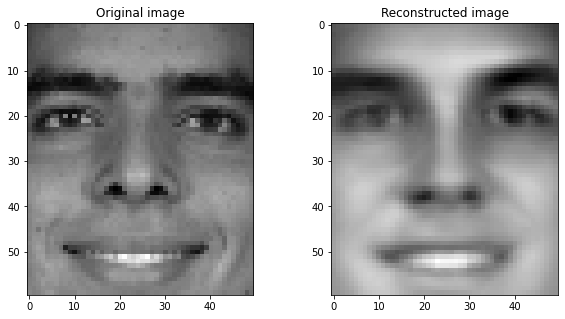

In [7]:
reconstructed_face_vector = (eigenvectors[:, :num_of_eigenvectors]).dot(projected_face) + average_face_vector

# Visualize the reconstructed face
face = face_vector.reshape(60, 50)
reconstructed_face = reconstructed_face_vector.reshape(60, 50)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(face, cmap='gray'), plt.title('Original image')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap='gray'), plt.title('Reconstructed image')
plt.show()

It's now starting to look more like the original face. Let's try the same, but this time use the first 100 principal components.

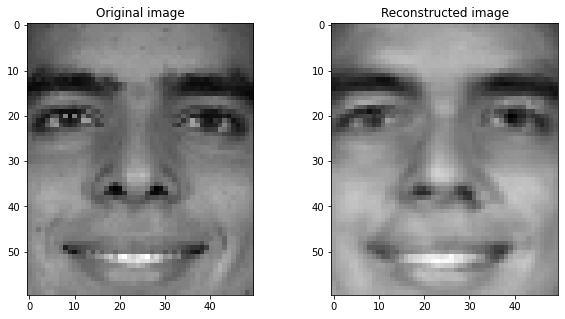

In [8]:
num_of_eigenvectors = 100     # Number of eigenvectors to use

projected_face = (eigenvectors[:, :num_of_eigenvectors].T).dot(face_vector_normalized)

reconstructed_face_vector = (eigenvectors[:, :num_of_eigenvectors]).dot(projected_face) + average_face_vector

# Visualize the reconstructed face
face = face_vector.reshape(60, 50)
reconstructed_face = reconstructed_face_vector.reshape(60, 50)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(face, cmap='gray'), plt.title('Original image')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap='gray'), plt.title('Reconstructed image')
plt.show()

200 Principal Components

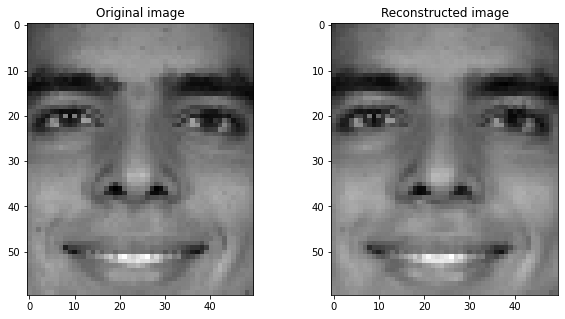

In [9]:
num_of_eigenvectors = 200     # Number of eigenvectors to use

projected_face = (eigenvectors[:, :num_of_eigenvectors].T).dot(face_vector_normalized)

reconstructed_face_vector = (eigenvectors[:, :num_of_eigenvectors]).dot(projected_face) + average_face_vector

# Visualize the reconstructed face
face = face_vector.reshape(60, 50)
reconstructed_face = reconstructed_face_vector.reshape(60, 50)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(face, cmap='gray'), plt.title('Original image')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap='gray'), plt.title('Reconstructed image')
plt.show()

Now the reconstructed face looks much more like the original face. What this shows us is that we can reduce the dimensionality of the face image from 3000 to 200 or 100 and still retain most of the information.

Next, let's bundle the PCA code that we have written into functions, so that we can easily reuse them.

In [10]:
# A function that computes the PCA of a set of vectors
def computePCA(data_vectors, average_vector, n_components):
    if n_components > min(data_vectors.shape[1], data_vectors.shape[1]):
        print('Number of components must be less than or equal  to the smallest between number of features and number of samples')
        print("Setting number of components to", min(data_vectors.shape[1], data_vectors.shape[1]))
        n_components = min(data_vectors.shape[1], data_vectors.shape[1])

    # Normalize each face vector by subtracting the average face vector
    data_vectors_normalized = data_vectors - average_vector

    # Compute the eigenvectors and eigenvalues
    covariance_matrix = np.cov(data_vectors_normalized, rowvar = True)

    # Step 4: Compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort the eigenvectors and eigenvalues in descending order of eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    return eigenvectors[:, :n_components]

# A function that projects a set of vectors onto a set of eigenvectors
def pca_project(data_vectors, eigenvectors, average_vector):
    data_vectors_normalized = data_vectors - average_vector
    return eigenvectors.T.dot(data_vectors_normalized)

# A function that reconstructs a set of vectors from a set of eigenvectors
def pca_reconstruct(projected_data, eigenvectors, average_vector):
    # Reconstruct the data
    return eigenvectors.dot(projected_data) + average_vector

### Face recognition using PCA

The face recognition algorithm using PCA is implemented as follows:
- 1. Create a dataset of a few face image samples of each person that we want to recognize. We will call this the **training set**.
- 2. Compute the PCA of the training set.
- 3. Project the training set onto the PCA. This will effectively project each face image in our training set onto a subspace of lower dimension.
- 4. For every new face (**test face**) that we want to recognize, project the test face onto the same subspace as the training set.
- 5. Find the closest match to the projected face by comparing the subspace vector distance between the test face and training set faces.

The idea is that the test face is more likely to be closer to a face image in the training set that came from the same person. By projecting the faces to a lower dimensional subspace, we can reduce the dimensionality of the faces and thus the amount of information that we need to store in the database. This allows us to store less information in the database, which can make it more efficient and faster to search for faces in the database. The downside is that we lose some information when we reduce the dimensionality of the faces. However, that can also be an advantage, as the the lost information is more likely to be details that differ from between different image samples of the same person. Features that are constant across different images of the same person will likely be considered as important and be retained in the top eigenvectors.

In this example, we will create a dataset of 10 people with 5 face images each. 

In [11]:
import os   # For listing the files in a directory

# Load training face data from 'data/face_recongition_db/train_data' folder
train_data_path = 'data/face_recongition_db/train_data'
train_data = []
train_labels = []
for dirname, dirnames, filenames in os.walk(train_data_path):
    for subdirname in dirnames:
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
            if filename.endswith('.bmp'):
                subject_file_path = os.path.join(subject_path, filename)
                face_img = cv.imread(subject_file_path, cv.IMREAD_GRAYSCALE)
                face_img = face_img[25:85, 25:75]
                face_vector = face_img.flatten()
                face_vector = face_vector[:, np.newaxis]
                train_data.append(face_vector)
                train_labels.append(int(subdirname))

# Convert the face vectors to a numpy array
train_data = np.column_stack(train_data)

# Load training face data from 'data/face_recongition_db/test_data' folder
test_data_path = 'data/face_recongition_db/test_data'
test_data = []
test_labels = []
for dirname, dirnames, filenames in os.walk(test_data_path):
    for subdirname in dirnames:
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
            if filename.endswith('.bmp'):
                subject_file_path = os.path.join(subject_path, filename)
                face_img = cv.imread(subject_file_path, cv.IMREAD_GRAYSCALE)
                face_img = face_img[25:85, 25:75]
                face_vector = face_img.flatten()
                face_vector = face_vector[:, np.newaxis]
                test_data.append(face_vector)
                test_labels.append(int(subdirname))

test_data = np.column_stack(test_data)

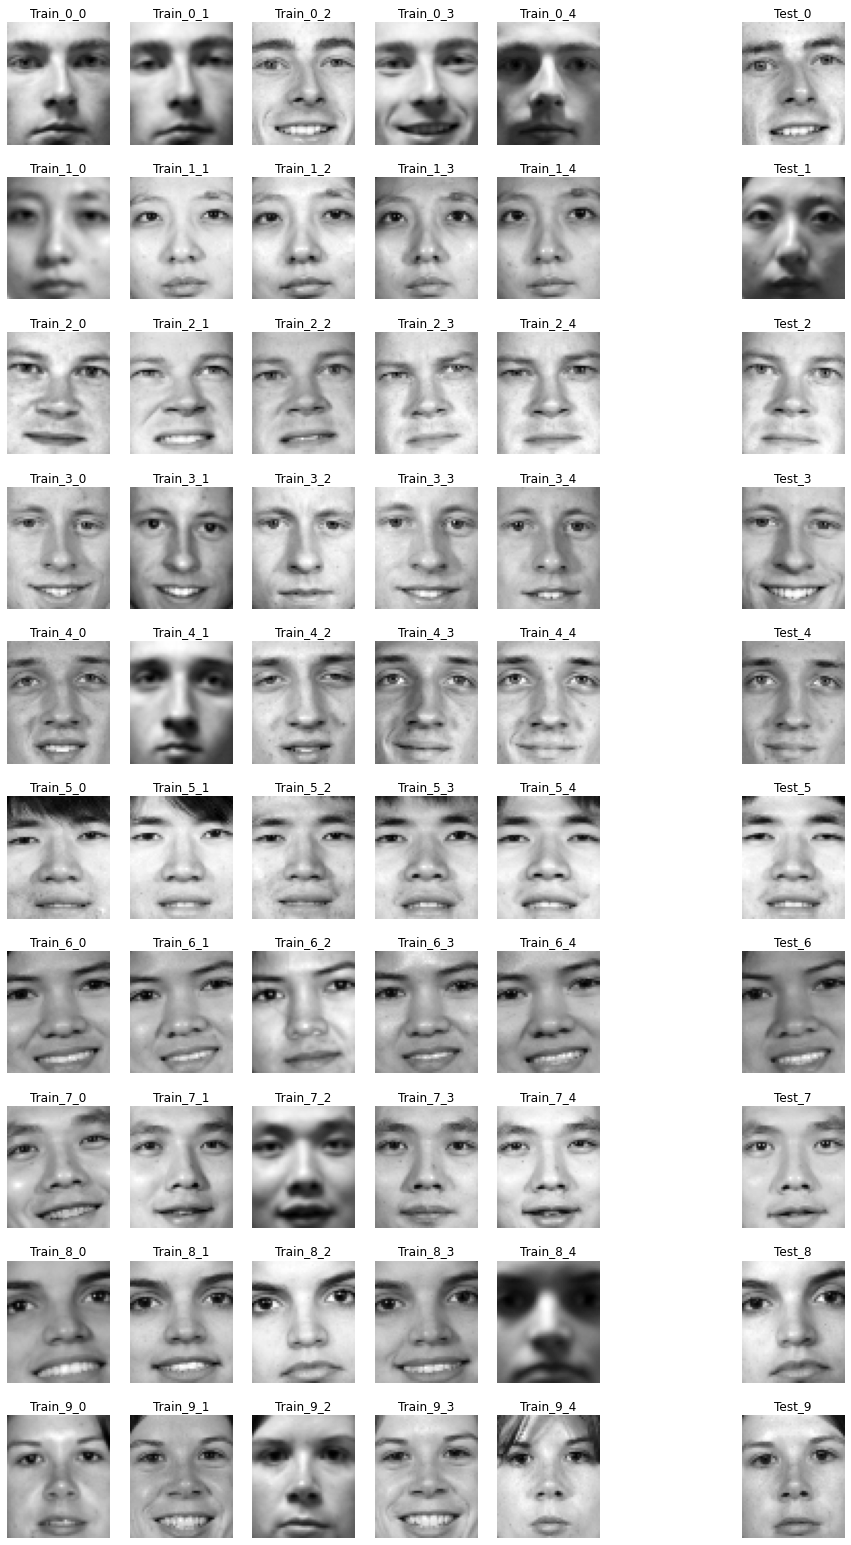

In [12]:
# Visualize the training and test data
plt.figure(figsize=(15, 28))
for i in range(10):
    for j in range(5):
        plt.subplot2grid((10, 7), (i, j))
        plt.imshow(train_data[:, i*5+j].reshape(60, 50), cmap='gray')
        plt.title('Train_' + str(i) + '_' + str(j)), plt.axis('off')
    plt.subplot2grid((10, 7), (i, 6))
    plt.imshow(test_data[:, i].reshape(60, 50), cmap='gray')
    plt.title('Test_' + str(i)), plt.axis('off')
plt.show()

Computer PCA on the training set.

In [13]:
average_vector = np.mean(train_data, axis=1)
average_vector = average_vector[:, np.newaxis]

# Compute PCA on the training data
eigenvectors = computePCA(train_data, average_vector, n_components=20)

# Project all training data onto the first 50 eigenvectors
train_data_projected = pca_project(train_data, eigenvectors, average_vector)

# Reconstruct the training data
train_data_reconstructed = pca_reconstruct(train_data_projected, eigenvectors, average_vector)

# # Display original and reconstructed training data for each training face (FOR DEBUGGING)

# print('Average face:')
# plt.imshow(average_vector.reshape(60, 50), cmap='gray')
# plt.show()

# for i in range(train_data_projected.shape[1]):
#     plt.subplot2grid((1, 2), (0, 0))
#     plt.imshow(train_data[:, i].reshape(60, 50), cmap='gray')
#     plt.title('Original_' + str(i)), plt.axis('off')
#     plt.subplot2grid((1, 2), (0, 1))
#     plt.imshow(train_data_reconstructed[:, i].reshape(60, 50), cmap='gray')
#     plt.title('Reconstructed_' + str(i)), plt.axis('off')
#     plt.show()
#     distance = np.linalg.norm(train_data[:, i] - train_data_reconstructed[:, i])
#     print("Distance: ", distance)

Classify test faces into one of the 10 people in the training set.

True label:  0 , Closest match:  14 , Predicted label:  2  distance:  921.6382534307388


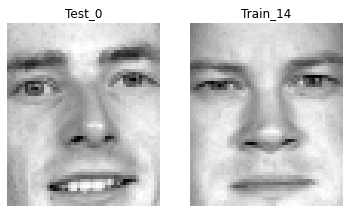

True label:  1 , Closest match:  37 , Predicted label:  7  distance:  1341.7341357246494


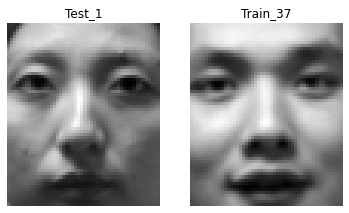

True label:  2 , Closest match:  13 , Predicted label:  2  distance:  888.8578453121265


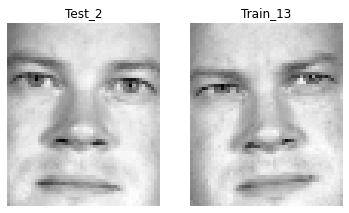

True label:  3 , Closest match:  17 , Predicted label:  3  distance:  836.1678914151985


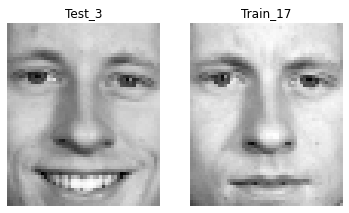

True label:  4 , Closest match:  24 , Predicted label:  4  distance:  869.4719583830654


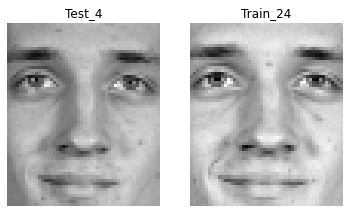

True label:  5 , Closest match:  29 , Predicted label:  5  distance:  910.2583768367602


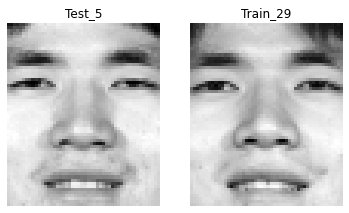

True label:  6 , Closest match:  35 , Predicted label:  7  distance:  1009.6142979133717


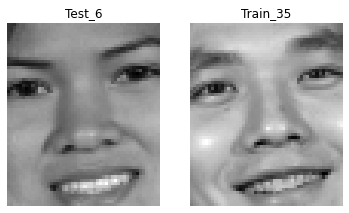

True label:  7 , Closest match:  6 , Predicted label:  1  distance:  897.6205147212979


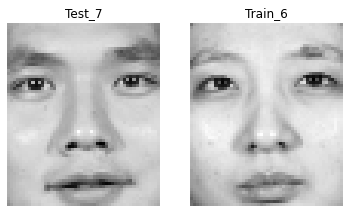

True label:  8 , Closest match:  41 , Predicted label:  8  distance:  1043.3655565087809


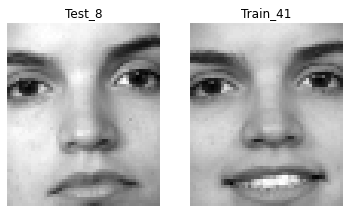

True label:  9 , Closest match:  45 , Predicted label:  9  distance:  762.4341432292345


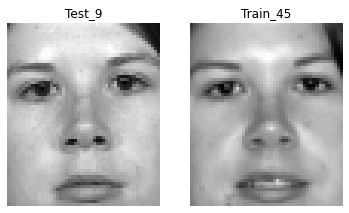

In [14]:
# For each face in the test set, find the closest match in the training set
# The distance between the test face and the training face is the Euclidean distance
# The Euclidean distance is the square root of the sum of the squares of the differences between the two vectors
for i in range(test_data.shape[1]):
    test_face_vector = test_data[:, i]
    test_face_vector = test_face_vector[:, np.newaxis]
    test_face_vector_projected = pca_project(test_face_vector, eigenvectors, average_vector)
    
    distances = np.sqrt(np.sum(np.square(train_data_projected - test_face_vector_projected), axis=0))
    min_index = np.argmin(distances)
    
    print("True label: ", i, ", Closest match: ", min_index, ", Predicted label: ", train_labels[min_index], " distance: ", distances[min_index])
    plt.subplot2grid((1, 2), (0, 0))
    plt.imshow(test_face_vector.reshape(60, 50), cmap='gray')
    plt.title('Test_' + str(i)), plt.axis('off')
    plt.subplot2grid((1, 2), (0, 1))
    plt.imshow(train_data[:, min_index].reshape(60, 50), cmap='gray')
    plt.title('Train_' + str(min_index)), plt.axis('off')
    plt.show()

As we can see, most of the test faces are classified into the same person as the training faces, but not all of them. PCA-based face recognition is not the most robust algorithm for face recognition, but it is a good way to demonstrate the power of PCA. Recently, much more accurate algorithms have been developed, based on Deep Learning methods.